<a href="https://colab.research.google.com/github/gdezan/image-resizing/blob/master/image_resizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redimensionando imagem sem distorcê-las
---

## Detalhes
Usando o algoritmo de "_seam carving_", nós receberemos como INPUT, qualquer imagem que necessite de redimensionamento para se encaixar em um certo tamanho, e iremos produzir uma nova versão da imagem, se encaixando no tamanho especificado e sem distorções visíveis. Essas imagens serão adquiridas de algum repositório público ou tiradas por nós mesmos.

**Tarefa de processamento de imagem**: Transformação de imagem.

**Aplicação**: Qualquer imagem que necessite de redimensionamento.

### Alunos

* Gabriel de Andrade Dezan - gabrieldezan@usp.br
* Ivan Mateus de Lima Azevedo - ivanmateusla@usp.br

## Início


A imagem que usaremos para conduzir o teste será a seguinte:

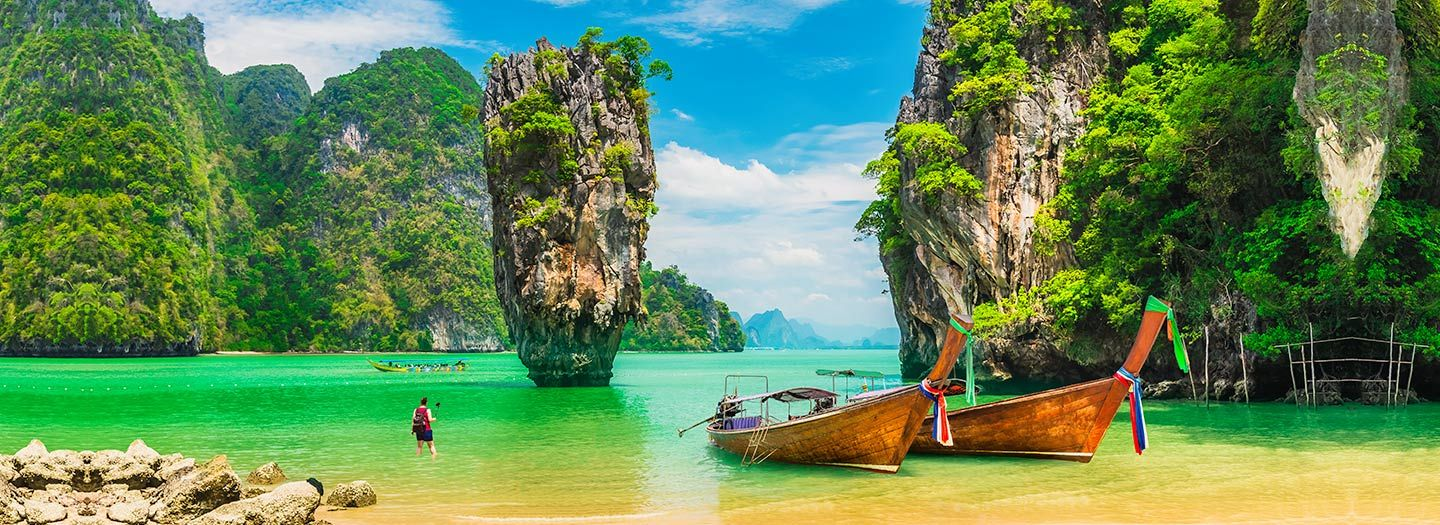

Ela possui 1440 pixels de largura, mas queremos reduzir essa largura para 1200. Se fizermos isso num editor de imagens padrão, teríamos a imagem achatada ou cortada para se encaixar no tamanho.

Imagem achatada:
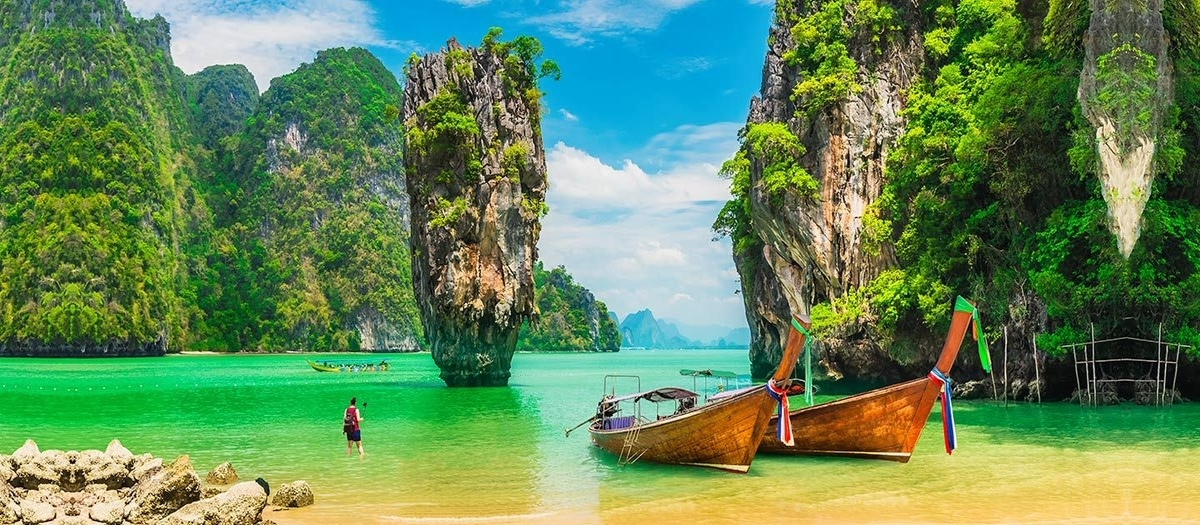

O que não é o nosso objetivo. Queremos deixar a imagem menor, sem distorcer ou perder conteúdo importante.

É aí que entra o algoritmo de "_seam carving_". Nos passos a seguir, iremos implementar o algoritmo em _python_ e redimensionar a imagem tentando ao máximo não distorcer a mesma e mantendo o conteúdo considerando importante.

Importando as bibliotecas necessárias:

- sys, para fazer a leitura de argumentos
- numpy, para algumas funções úteis
- IPython.display, para mostrarmos as imagens
- scipy.ndimage.filters, para fazer a operação de convolução entre o filtro e a imagem
- imageio, para ler e escrever as imagens
- numba, para otimizar o código
- warnings, para suprimir os warnings

In [151]:
import sys
import numpy as np
from IPython.display import Image
from scipy.ndimage.filters import convolve
from imageio import imread, imwrite
import numba
import warnings
warnings.filterwarnings('ignore')

O algoritmo funciona da seguinte forma:
  * Primeiro ele gera um mapa de energia para cada pixel da imagem - a energia de um pixel será determinada pelos pixels em sua proximidade e o quão acentuada é a variação de cor (que pode determinar uma borda)
  * Acha um caminho do topo à base da imagem (se estiver reduzindo a largura da imagem) ou de um lado ao outro da mesma (redução de altura) que consiste nos pixels geram o caminho de menor energia.
  * Elimina esse caminho encontrado
  * Repete os passos anteriores até a imagem se enquadrar no tamanho desejado


## Mapa de energia

Vimos então que o primeiro passo do algoritmo é a criação do mapa de energia para os pixels da imagem. Para calcularmos a energia de um pixel, vamos usar o filtro diferencial de Laplace. O kernel original do filtro pode ser visualizado na imagem abaixo. Porém, este kernel considera somente as variações na horizontal e na vertical, portanto utilizamos uma variação dele, que inclui as mudanças nas diagonais também. E, para melhor aproximação, utilizamos um kernel 5x5, ao invés de um 3x3. Dessa forma, fazemos uma convolução desse kernel com a imagem e o valor absoluto dessa operação será a energia do pixel.

Kernel 3x3 do filtro de Laplace

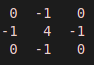

Kernel modificado 3x3 do filtro de Laplace (considerando diagonais)

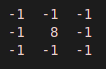

Kernel modificado 5x5 do filtro de Laplace (considerando diagonais)

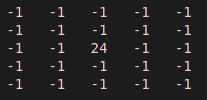

In [152]:
@numba.jit
def get_energy_map(img):
    # Cria o kernel 5x5 do filtro diferencial de Laplace, para melhor aproximação
    laplace_kernel = np.array([
        [-1.0, -1.0, -1.0, -1.0, -1.0],
        [-1.0, -1.0, -1.0, -1.0, -1.0],
        [-1.0, -1.0, 24.0, -1.0, -1.0],
        [-1.0, -1.0, -1.0, -1.0, -1.0],
        [-1.0, -1.0, -1.0, -1.0, -1.0],
    ])
    # Aqui transformamos o filtro de 2D pra 3D, para fazermos
    # a convolução dele nos três canais da imagem (R, G e B)
    laplace_kernel = np.stack([laplace_kernel] * 3, axis=2)

    # Convertemos a imagem para float 32 e convoluímos ela com o filtro,
    # para então calcularmos o valor absoluto desse resultado
    img = img.astype(np.float32)
    convolved = np.absolute(convolve(img, laplace_kernel))

    # Esse valor é somado para os três canais da imagem e o resultado é o mapa de energia
    energy_map = convolved.sum(axis=2)

    return energy_map

Podemos testar a criação do mapa de energia usando uma imagem

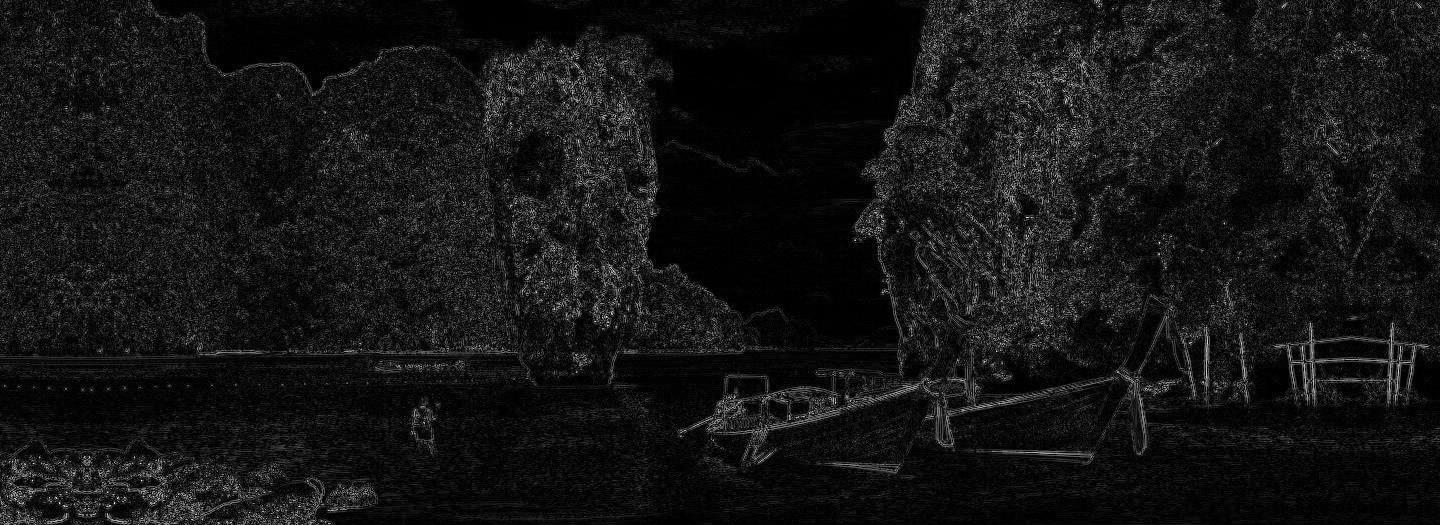

In [153]:
img = imread("test_image.jpg")
imwrite("energy_map.jpg", get_energy_map(img))
Image("energy_map.jpg", height=400)

Esse é o resultado do mapa de energia da imagem. Pixels mais claro representam uma energia maior. Podemos ver que se assemelha a uma imagem que destaca as bordas, o que era de se esperar por conta do filtro que usamos.

## Encontrar o caminho de menor energia



Agora, temos que encontrar o caminho de menor energia total de pixels indo do topo até a base da imagem (nesse caso iremos reduzir a largura da imagem). Para isso, podemos usar algoritmos de _pathfinding_ como o _A*_, por exemplo, pois a rota de menor de energia total dos pixels é basicamente equivalente a uma rota de menor distância.

Porém, como teríamos que calcular isso para todos os pixels da imagem (que tendem a ser muitos) teríamos que rodar esse algoritmo, que é razoavelmente custoso, muitas vezes. Por isso que usamos, então, conceitos da programação dinâmica para nos ajudar no processo.

Começamos criando uma matriz do tamanho da imagem onde cada elemento da matriz é um pixel da imagem. Em cada elemento, iremos guardar o menor total de energias encontrados até esse pixel, considerando todos os caminhos vindo do topo da imagem até esse pixel específico. Portanto, o caminho com total de energias com menor valor possível estará na ultima linha de pixels da imagem (última linha da matriz). Encontrando esse valor, basta subirmos da ultima linha até a primeira, pegando os elementos com menor valor. Esse caminho será o caminho que iremos remover.

In [154]:
@numba.jit
def get_minimum_energy_path(image):
    rows = image.shape[0]
    cols = image.shape[1]

    # Calcula o mapa de energia para a imagem
    energy_map = get_energy_map(image)

    # Tabela de "programação dinâmica", que irá armazenar as menores energiais
    # totais até o pixel de cada elemento
    dp_table = energy_map.copy()

    # Tabela com os indíces que irão compor o caminho final
    backtrack = np.zeros_like(dp_table, dtype=np.int)

    for i in range(1, rows):
        for j in range(0, cols):
            # Se for a primeira coluna, utiliza j ao invés de j - 1, para
            # não utilizarmos um índice negativo
            # Para ambos os casos (if e else):
            # - Procura o índice do elemento de menor energia
            # - Guarda ele na matriz de backtracking
            # - Pega o valor de menor energia
            # - Soma esse valor na posição atual (i, j) da tabela de programação dinâmica
            if j == 0:
                idx = np.argmin(dp_table[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = dp_table[i - 1, idx + j]
            else:
                idx = np.argmin(dp_table[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = dp_table[i - 1, idx + j - 1]

            dp_table[i, j] += min_energy

    # Cria uma matriz do tamanho da imagem preenchida de valores True
    path = np.ones((rows, cols), dtype=np.bool)

    # Procupa o pixel de menor energia da última linha da imagem
    j = np.argmin(dp_table[-1])

    for i in range(rows - 1, -1, -1):
        # Marca os pixels de menor energia como False,
        # para montar o caminho de menor energia
        path[i, j] = False
        j = backtrack[i, j]

    # Converte o path para 3 dimensões, pois a imagem está em RGB
    path = np.stack([path] * 3, axis=2)

    return path

In [155]:
# Função auxiliar para pintar o caminho que será retirado
def paint_pixels(image, path):
  rows, col, _ = image.shape

  painted_image = image.copy()
  for i in range(1, rows):
        for j in range(0, col):
          if path[i][j][0] == False:
          # Se o pixel fizer parte do caminho de menor energia,
          # pinta ele de vermelho
            painted_image[i][j][0] = 255
            painted_image[i][j][1] = 0
            painted_image[i][j][2] = 0
  return painted_image

Imagem com o primeiro caminho de menor energia total a ser retirado

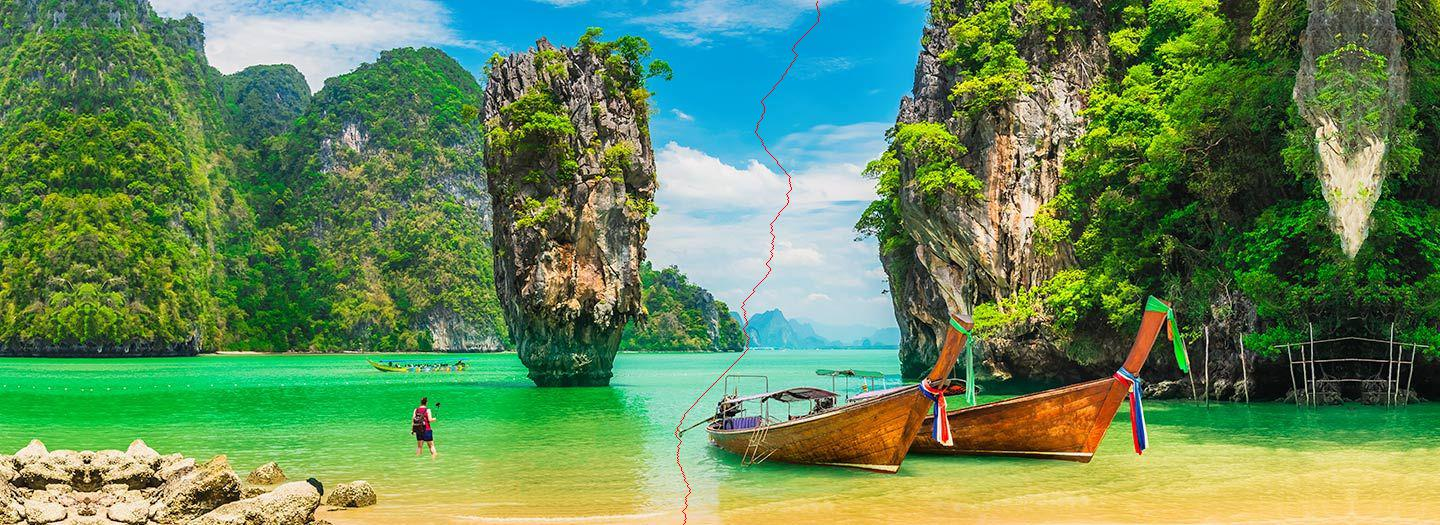

In [156]:
minimum_energy_path = get_minimum_energy_path(img)
painted = paint_pixels(img, minimum_energy_path)
imwrite("painted.jpg", painted)
Image("painted.jpg", height=400)

O caminho pintado de vermelho será o caminho a ser retirado, diminuindo a largura da imagem em 1 pixel.

In [157]:
@numba.jit
def erase_path(img, path):
    r, c, _ = img.shape

    # Procura os pixels de menor energia e deleta eles
    img = img[path].reshape((r, c - 1, 3))

    return img

def resize_width(img, new_width):
    r, c, _ = img.shape

    # Calcula a diferença entre a largura atual da imagem
    # e a que se deseja chegar e remove o mesmo número de caminhos de 
    for i in range(c - new_width):
        path = get_minimum_energy_path(img)
        img = erase_path(img, path)

    return img

Agora com as funções declaradas, basta chamarmos a função para redimensionar a largura da imagem:

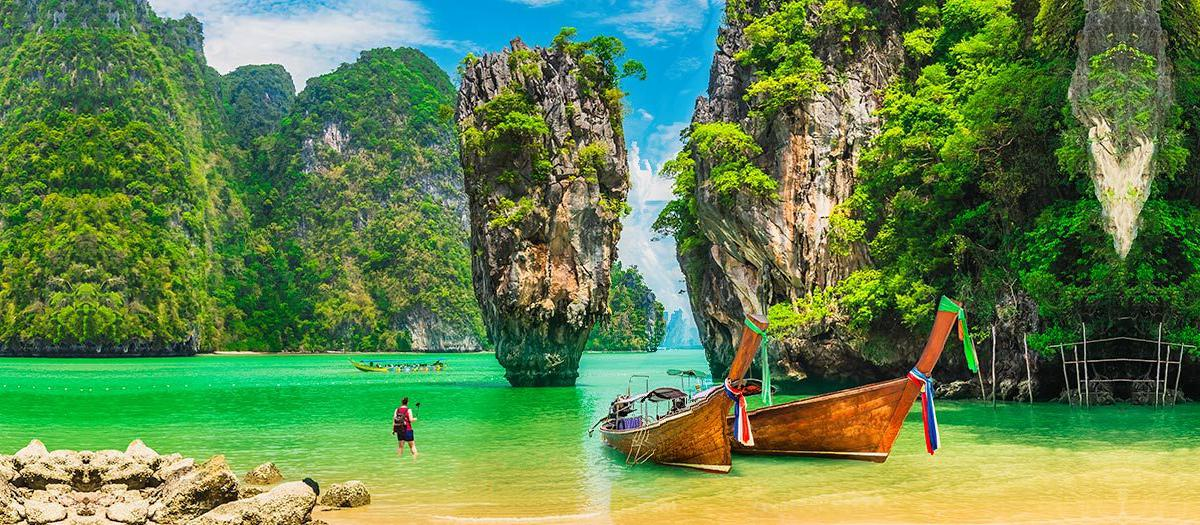

In [158]:
cropped = resize_width(img, 1200)
imwrite("cropped.jpg", cropped)
Image("cropped.jpg", height=400)

Para efeitos de comparação, temos aqui o "antes" e "depois":

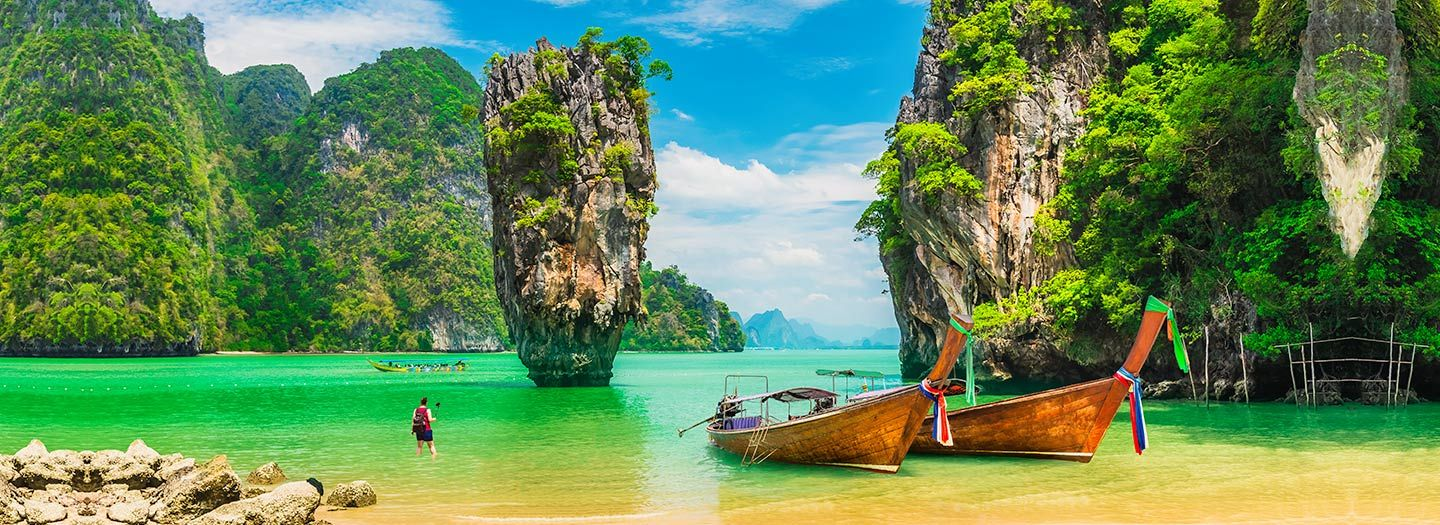

In [159]:
Image("test_image.jpg", height=400)

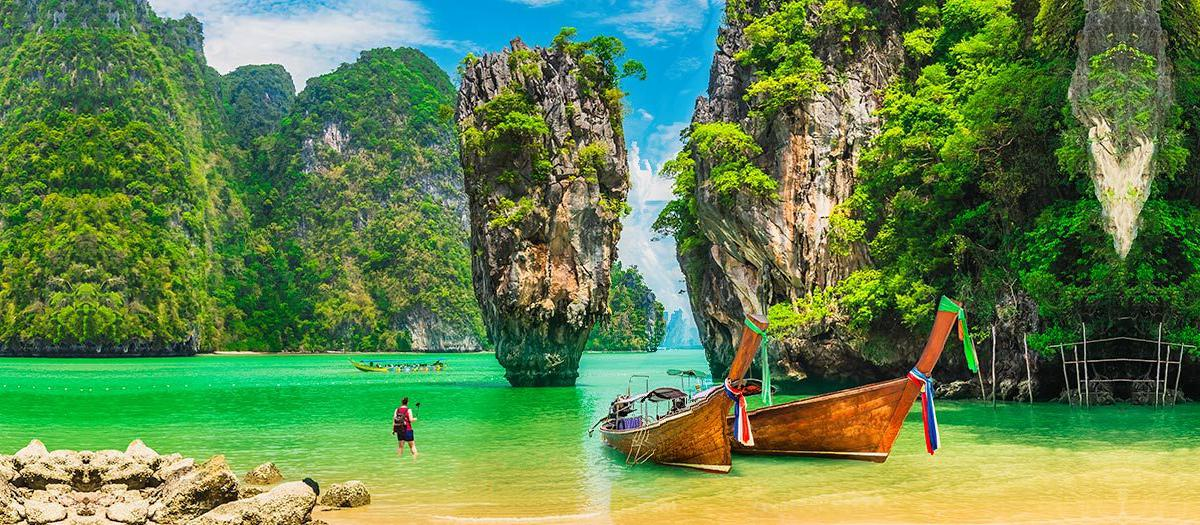

In [160]:
Image("cropped.jpg", height=400)

Note como ele mantém as montanhas, as pedras e a pessoa na água intactos, removendo o meio da imagem, com o céu azul no fundo, onde se tem menos "bordas", dando uma energia, e por consequência, importância, menor para a área.